In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [8]:
#构造数据集
# y=Xw+b+噪声
#w=[2,-3.4]T
# b=4.2
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))# n个样本 
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)#均值为0  方差为0.01
    return X,y.reshape((-1,1))
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w, true_b,1000)

In [9]:
print('features:',features[0],'\nlabel:',labels[0])


features: tensor([-1.6745, -0.6219]) 
label: tensor([2.9569])


(1000,) (1000, 1)


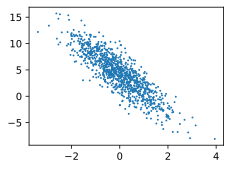

In [28]:
#特征和label的关系
d2l.set_figsize()
print(features[:,1].detach().numpy().shape,labels.detach().numpy().shape)
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy().reshape(-1),1)#绘制散点图


In [29]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)# indices 索引 shuffle 打乱
    for i in range(0, num_examples, batch_size):
    # range(0, num_examples, batch_size)：从 0 到 num_examples（样本总数）以 batch_size（批量大小）为步长的范围
    # 中文意思：从 0 开始，每次以 batch_size 为步长，直到 num_examples，循环变量 i 表示当前批次的起始索引。

        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        # batch_indices：批次索引，存储当前批次的数据索引
        # torch.tensor: 把输入的数据转换为 PyTorch 张量
        # indices: 数据集索引
        # i：当前批次的起始索引
        # min(i + batch_size, num_examples): 计算当前批次的结束索引，确保不超过样本总数
        # 中文意思：从数据索引列表 indices 中，选取当前批次的索引范围（从 i 到 i + batch_size，不超过样本总数），并将其转换为 PyTorch 张量，赋值给 batch_indices。

        yield features[batch_indices], labels[batch_indices]
        # yield：生成器的关键字，暂时返回数据而不终止函数
        # features: 特征矩阵
        # labels: 标签矩阵
        # batch_indices: 当前批次的数据索引
        # 中文意思：根据当前批次的索引，从特征矩阵和标签矩阵中提取对应的批次数据，并通过 yield 关键字返回特征和标签，供调用方使用。


batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.4749,  0.3822],
        [-0.7305,  0.9607],
        [-1.3550,  0.0674],
        [ 1.5149,  0.2558],
        [ 2.8521,  0.0558],
        [ 0.2196, -1.3028],
        [-1.2977, -0.0651],
        [ 0.7629,  1.1372],
        [ 0.7177,  1.7791],
        [ 0.8192,  1.1368]]) 
 tensor([[ 3.8509],
        [-0.5307],
        [ 1.2417],
        [ 6.3698],
        [ 9.7124],
        [ 9.0608],
        [ 1.8175],
        [ 1.8602],
        [-0.4128],
        [ 1.9655]])


In [68]:
"""初始化模型参数"""
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# w: 权重 (weights) - 参数矩阵
# torch.normal: 生成正态分布随机数 (torch.normal stands for generating random numbers from a normal distribution)
# 0: 均值 (mean)
# 0.01: 标准差 (standard deviation)
# size=(2, 1): 生成一个 2 行 1 列的张量
# requires_grad=True: 设置为需要计算梯度，用于自动求导
# 中文意思：使用均值为 0、标准差为 0.01 的正态分布生成一个 2×1 的权重张量，并设置 `requires_grad=True`，表示该张量在进行反向传播时会计算梯度。

b = torch.zeros(1, requires_grad=True)
# b: 偏置 (bias) - 参数向量
# torch.zeros: 生成全 0 的张量 (torch.zeros stands for generating a tensor filled with zeros)
# 1: 大小为 1 的张量
# requires_grad=True: 设置为需要计算梯度，用于自动求导
# 中文意思：生成一个大小为 1 的偏置张量，值为 0，并设置 `requires_grad=True`，表示该张量在进行反向传播时会计算梯度。


In [69]:
"""定义模型"""
def linreg(X,w,b):
    return torch.matmul(X,w)+b

In [70]:
"""定义损失函数"""
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [72]:
"""定义优化算法"""
def sgd(params,lr,batch_size):# sgd: stochastic gradient descent 
    # params: parameters
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -=lr*param.grad/batch_size# 参数=参数-学习率*（参数梯度/批量大小）  要除以批量大小是因为参数梯度是一个批次的梯度的累加值  需要求平均
            param.grad.zero_()


In [79]:
lr=0.04###学习率太大可能除0 会成为nan
num_epochs=7
net=linreg
loss=squared_loss

for epoch in range(num_epochs):#训练的轮数  每次对数据扫一遍
    for X,y in data_iter(batch_size,features,labels):# 每一次拿批次
        l=loss(net(X,w,b),y)#把X w b放到network里做预测，再把y^hat与真实的y计算损失
        #求和loss 反向传播算梯度
        l.sum().backward()
        # 用sgd进行参数更新
        sgd([w,b],lr,batch_size)# 最后一批的batch_size要
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1}, loss{float(train_l.mean()):.10f}')

epoch1, loss0.0000495969
epoch2, loss0.0000495739
epoch3, loss0.0000497468
epoch4, loss0.0000498884
epoch5, loss0.0000496285
epoch6, loss0.0000496227
epoch7, loss0.0000497590


In [74]:
##比较真实参数和训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.1227, -0.1606], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.2012], grad_fn=<RsubBackward1>)
